# Pytorch Tutorial 8

## RNN 1
This script shows how to predict stock prices using a basic RNN

GE데이터 2014-1-1 부터 2017-7-17 데이터로 예측

    Min Max Normalization
    Parameters ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]

    Returns ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]

    References ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html

In [1]:
# train Parameters
learning_rate = 0.01
num_epochs = 500
input_size = 5
hidden_size = 5
num_classes = 1
timesteps = seq_length = 7
num_layers = 1  # number of layers in RNN

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import os
from time import time; t0 = time()
torch.manual_seed(777)  # reproducibility

In [3]:
if "DISPLAY" not in os.environ:
    matplotlib.use('Agg') # remove Travis CI Error

In [4]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [5]:
# Open, High, Low, Volume, Close
# xy = np.loadtxt('./Lecture/data-02-stock_daily.csv', delimiter=',')
xy = np.loadtxt('./Lecture/ge.csv', delimiter=',')

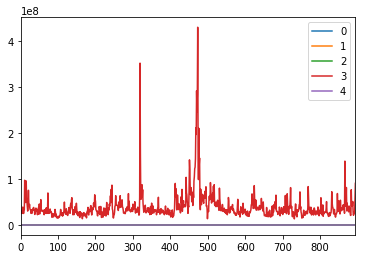

In [6]:
%matplotlib inline
# 데이터 내용 살펴보기
import pandas as pd
csv_data = pd.DataFrame(xy)
csv_data.plot()

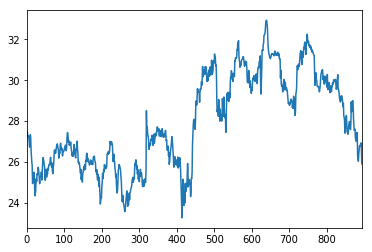

In [7]:
# Close 가격 데이터 살펴보기
csv_data.ix[:,4].plot()

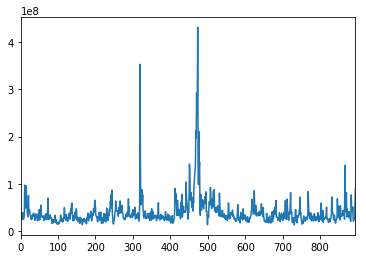

In [8]:
# Volume 데이터 살펴보기
csv_data.ix[:,3].plot()

In [9]:
#xy = np.loadtxt('./Lecture/google.csv', delimiter=',')
xy = xy[::-1]  # reverse order (chronically ordered)
xy = MinMaxScaler(xy)
x = xy
y = xy[:, [-1]]  # Close as label

In [10]:
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next close price
    dataX.append(_x)
    dataY.append(_y)
    if i % 150 == 0:
        print(_x, "->", _y)

[[ 0.25098814  0.2513369   0.44053852  0.18547142  0.27329192]
 [ 0.41304347  0.36363636  0.5407629   0.10051975  0.35403726]
 [ 0.39624506  0.36149732  0.55871353  0.02783741  0.37991718]
 [ 0.38735177  0.34973262  0.5512341   0.03107761  0.3747412 ]
 [ 0.38735177  0.34545454  0.54973822  0.03478655  0.36749482]
 [ 0.38537549  0.34759358  0.55048616  0.01889966  0.36335403]
 [ 0.36956521  0.34010695  0.53328347  0.03495887  0.36438923]] -> [ 0.3426501]
[[ 0.86660078  0.89090908  0.90276738  0.07303483  0.85196686]
 [ 0.89525691  0.89304812  0.91548242  0.05107428  0.87681159]
 [ 0.87252964  0.8919786   0.91922213  0.04279323  0.88923395]
 [ 0.85079051  0.88449197  0.89603589  0.04324001  0.88095237]
 [ 0.86561264  0.86096256  0.89977561  0.03586229  0.85507245]
 [ 0.80731224  0.85026737  0.86462228  0.04723631  0.86231883]
 [ 0.82509881  0.8117647   0.87060583  0.01055806  0.81780537]] -> [ 0.81159419]
[[ 0.6916996   0.70053475  0.78309648  0.08161178  0.70600413]
 [ 0.75691699  0.759

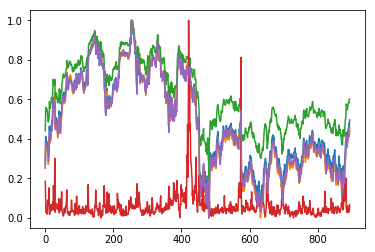

In [11]:
# 모델링 결과 데이터 overview
import matplotlib.pyplot as plt
plt.plot(xy)

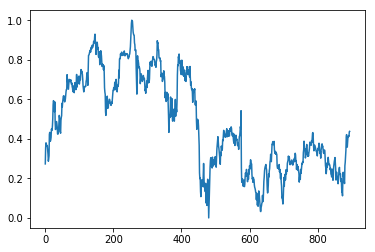

In [12]:
# Close 등의 가격 데이터
plt.plot(xy[:,4])

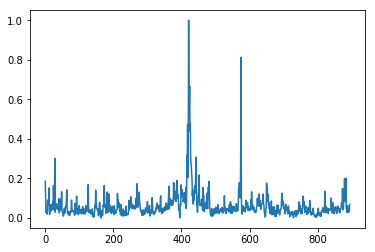

In [13]:
# Volume 데이터
plt.plot(xy[:,3])

In [14]:
# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX = torch.Tensor(np.array(dataX[0:train_size]))
trainX = Variable(trainX)
testX = torch.Tensor(np.array(dataX[train_size:len(dataX)]))
testX = Variable(testX)
trainY = torch.Tensor(np.array(dataY[0:train_size]))
trainY = Variable(trainY)
testY = torch.Tensor(np.array(dataY[train_size:len(dataY)]))
testY = Variable(testY)

In [15]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        # Set parameters for RNN block
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden and cell states
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        # Propagate input through LSTM
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out

In [16]:
# Instantiate RNN model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
# Set loss and optimizer function
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [17]:
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.data[0]))
print("Learning finished!")
print(int(time()-t0)//60, 'min', int(time()-t0)%60, 'sec')

Epoch: 0, loss: 0.33490
Epoch: 100, loss: 0.00139
Epoch: 200, loss: 0.00107
Epoch: 300, loss: 0.00088
Epoch: 400, loss: 0.00073
Learning finished!
0 min 9 sec


In [18]:
# Test the model
lstm.eval()
test_predict = lstm(testX)

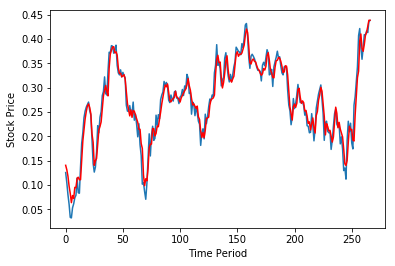

In [19]:
# Plot predictions
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
test_predict = test_predict.data.numpy()
testY = testY.data.numpy()
plt.plot(testY)
plt.plot(test_predict,'r')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

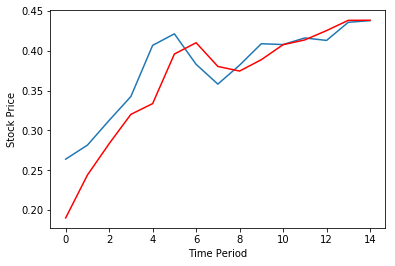

In [20]:
# Plot predictions
# GE는 가격의 지속적 상승이 예측
plt.plot(testY[-15:])
plt.plot(test_predict[-15:],'r')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

## RNN 2
predict Samsung Stock Prices using RNN

LG디스플레이 2014-1-1 부터 2017-7-17 까지의 주가 데이터를 활용

익일(D+1) 주가를 예측

In [21]:
# Open, High, Low, Volume, Close
xy = np.loadtxt('./Lecture/lgdisplay.csv', delimiter=',')
xy = xy[::-1]  # reverse order (chronically ordered)
xy = MinMaxScaler(xy)
x = xy
y = xy[:, [-1]]  # Close as label
t0 = time()

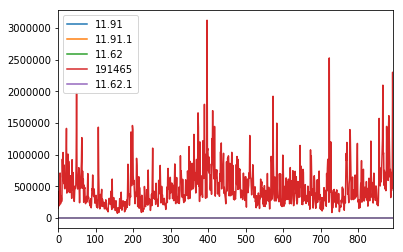

In [23]:
# 삼성전자 데이터 미리보기
import pandas as pd
lg = pd.read_csv('./Lecture/lgdisplay.csv')
lg.plot(kind='line')

In [24]:
# 바로 익일주가 예측모델링
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next close price
    dataX.append(_x)
    dataY.append(_y)
    if i % 150 ==0:
        print(_x, "->", _y)

[[ 0.74082073  0.67959183  0.75687568  0.32234392  0.75990939]
 [ 0.76889848  0.70612244  0.7260726   0.73060904  0.75651188]
 [ 0.90172785  0.83571428  0.92299229  0.12884213  0.91166477]
 [ 0.85097191  0.79387754  0.88118811  0.18062314  0.8856172 ]
 [ 0.84881209  0.77448979  0.86688668  0.11682017  0.86070214]
 [ 0.8336933   0.77346938  0.85698569  0.21226704  0.86070214]
 [ 0.85637148  0.79081632  0.88338833  0.08164798  0.87655718]] -> [ 0.87315967]
[[ 0.49460043  0.46020408  0.50935093  0.12155646  0.48471121]
 [ 0.49352051  0.45816326  0.5170517   0.10509119  0.51075877]
 [ 0.46112311  0.41020408  0.47854785  0.03174549  0.45979614]
 [ 0.48596112  0.43979591  0.50165016  0.10252968  0.4801812 ]
 [ 0.48704103  0.44183673  0.50715071  0.10824031  0.48697621]
 [ 0.46976241  0.42857142  0.48294829  0.09737423  0.4813137 ]
 [ 0.42656587  0.38877551  0.45214521  0.10560572  0.43035107]] -> [ 0.39184598]
[[ 0.262419    0.22653061  0.25632563  0.20418041  0.22876557]
 [ 0.22138229  0.19

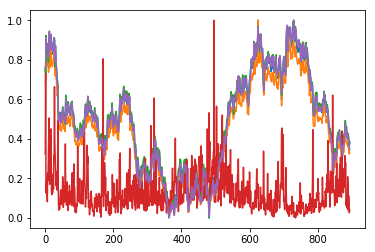

In [25]:
# 모델링 데이터 overview
plt.plot(xy)

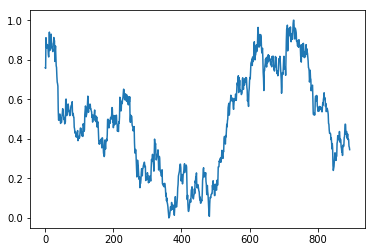

In [26]:
# Close 등의 가격 데이터
plt.plot(xy[:,4])

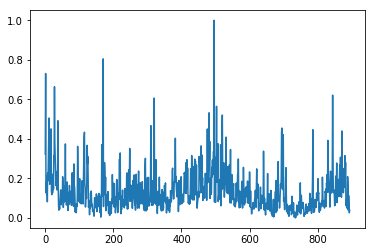

In [27]:
# Volume 데이터
plt.plot(xy[:,3])

In [28]:
# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX = torch.Tensor(np.array(dataX[0:train_size]))
trainX = Variable(trainX)
testX = torch.Tensor(np.array(dataX[train_size:len(dataX)]))
testX = Variable(testX)
trainY = torch.Tensor(np.array(dataY[0:train_size]))
trainY = Variable(trainY)
testY = torch.Tensor(np.array(dataY[train_size:len(dataY)]))
testY = Variable(testY)

In [29]:
# Instantiate RNN model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
# Set loss and optimizer function
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [30]:
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.data[0]))
print("Learning finished!")
print(int(time()-t0)//60, 'min', int(time()-t0)%60, 'sec')

Epoch: 0, loss: 0.60629
Epoch: 100, loss: 0.00125
Epoch: 200, loss: 0.00110
Epoch: 300, loss: 0.00101
Epoch: 400, loss: 0.00094
Learning finished!
0 min 28 sec


In [31]:
# Test the model
lstm.eval()
test_predict = lstm(testX)

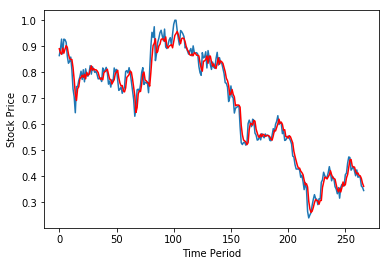

In [32]:
# Plot predictions
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
test_predict = test_predict.data.numpy()
testY = testY.data.numpy()
plt.plot(testY)
plt.plot(test_predict, 'r')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

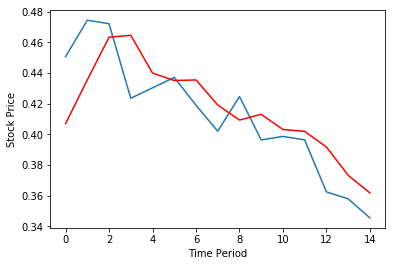

In [33]:
# 마지막 2주간 데이터 Detail View
# 보합 하락을 예측!!!
plt.plot(testY[-15:])
plt.plot(test_predict[-15:], 'r')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

## RNN 3
predict Samsung Stock Prices using RNN

삼성전자 2014-1-1 부터 2017-7-17 까지의 주가 데이터를 활용

5일 (Business Day + 5 == 1 week) 주가를 예측

In [34]:
# 바로 익일주가 예측모델링
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length - 5):
    _x = x[i: i + seq_length]
    _y = y[i + seq_length + 5]  # Next close price
    dataX.append(_x)
    dataY.append(_y)
    if i % 150 ==0:
        print(_x, "->", _y)

[[ 0.74082073  0.67959183  0.75687568  0.32234392  0.75990939]
 [ 0.76889848  0.70612244  0.7260726   0.73060904  0.75651188]
 [ 0.90172785  0.83571428  0.92299229  0.12884213  0.91166477]
 [ 0.85097191  0.79387754  0.88118811  0.18062314  0.8856172 ]
 [ 0.84881209  0.77448979  0.86688668  0.11682017  0.86070214]
 [ 0.8336933   0.77346938  0.85698569  0.21226704  0.86070214]
 [ 0.85637148  0.79081632  0.88338833  0.08164798  0.87655718]] -> [ 0.93997734]
[[ 0.49460043  0.46020408  0.50935093  0.12155646  0.48471121]
 [ 0.49352051  0.45816326  0.5170517   0.10509119  0.51075877]
 [ 0.46112311  0.41020408  0.47854785  0.03174549  0.45979614]
 [ 0.48596112  0.43979591  0.50165016  0.10252968  0.4801812 ]
 [ 0.48704103  0.44183673  0.50715071  0.10824031  0.48697621]
 [ 0.46976241  0.42857142  0.48294829  0.09737423  0.4813137 ]
 [ 0.42656587  0.38877551  0.45214521  0.10560572  0.43035107]] -> [ 0.39297848]
[[ 0.262419    0.22653061  0.25632563  0.20418041  0.22876557]
 [ 0.22138229  0.19

In [35]:
# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX = torch.Tensor(np.array(dataX[0:train_size]))
trainX = Variable(trainX)
testX = torch.Tensor(np.array(dataX[train_size:len(dataX)]))
testX = Variable(testX)
trainY = torch.Tensor(np.array(dataY[0:train_size]))
trainY = Variable(trainY)
testY = torch.Tensor(np.array(dataY[train_size:len(dataY)]))
testY = Variable(testY)

# Instantiate RNN model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
# Set loss and optimizer function
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [36]:
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.data[0]))
print("Learning finished!")
print(int(time()-t0)//60, 'min', int(time()-t0)%60, 'sec')

Epoch: 0, loss: 0.55503
Epoch: 100, loss: 0.00470
Epoch: 200, loss: 0.00450
Epoch: 300, loss: 0.00437
Epoch: 400, loss: 0.00427
Learning finished!
0 min 35 sec


In [37]:
# Test the model
lstm.eval()
test_predict = lstm(testX)

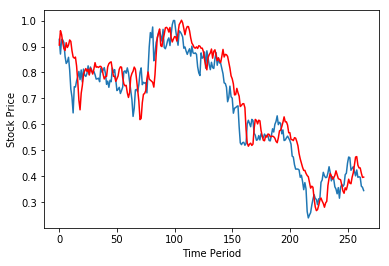

In [38]:
# Plot predictions
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
test_predict = test_predict.data.numpy()
testY = testY.data.numpy()
plt.plot(testY)
plt.plot(test_predict,'r')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

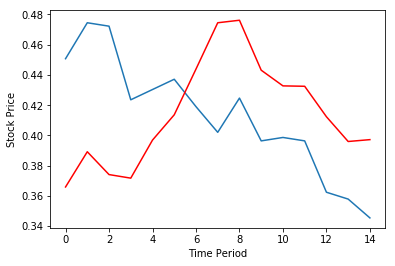

In [39]:
# 마지막 2주간 데이터 Detail View
# 추후 2일간 하락을 예측
plt.plot(testY[-15:])
plt.plot(test_predict[-15:], 'r')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()